In [1]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,8)
font = {'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

In [2]:
COUNTRIES = ["france", "germany", "spain", "england", "italy"]
YEARS = ["2012", "2013", "2014", "2015", "2016"]

In [3]:
def extract_features(df, row):
    hometeam = row["ht"]
    awayteam = row["at"]
    matchdate = row["date"]
    Y_test = 0
    if row.fthg > row.ftag:
        Y_test = "win"
    elif row.fthg < row.ftag:
        Y_test = "lose"
    else:
        return


    hteam = df.query('ht == @hometeam & date < @matchdate', inplace = False)[["fthg","ftag"]]
    ateam = df.query('at == @awayteam & date < @matchdate', inplace = False)[["fthg","ftag"]]

    # Not enough data
    if ateam.shape[0] < 4 or hteam.shape[0] < 4:
        return

    hwinrate = 0
    j = 0
    for i, r in hteam.iterrows():
        if r.fthg > r.ftag:
            hwinrate += 2
        elif r.fthg == r.ftag:
            hwinrate += 1
        j += 1
        if j > 4:
            break

    hwinrate /= min(hteam.shape[0], 5) * 2

    awinrate = 0
    j = 0
    for i, r in ateam.iterrows():
        if r.fthg < r.ftag:
            awinrate += 2
        elif r.fthg == r.ftag:
            awinrate += 1
        j += 1
        if j > 4:
            break

    awinrate /= min(ateam.shape[0], 5) * 2

    size1 = hteam.shape[0]
    size2 = ateam.shape[0]
    hgoals = hteam.sum()/size1
    agoals = ateam.sum()/size2

    #lscore = last.query('ht == @hometeam & at == @awayteam', inplace = False)
    hwin = 0.0
    #if lscore.shape[0] == 1:
        #if lscore.iloc[0]["fthg"] > lscore.iloc[0]["ftag"]:
            #hwin = 1.0
        
    return {
        "y":Y_test,
        "x":[ 
        hgoals.iloc[0],
        hgoals.iloc[1],
        agoals.iloc[0],
        agoals.iloc[1],
        hwinrate,
        awinrate,
    ]}

In [4]:
# Features preprocessing
X_train = []
Y_train = []
df = None
for country in COUNTRIES:
    for year in YEARS:
        df = pd.read_csv ('./DistributedData/' + country + '/' + year)
        df = df.sort_values(by=['date'], ascending= False)
        for index, row in df.iterrows():
            res = extract_features(df, row)   
            if res is not None:
                Y_train.append(res["y"])
                X_train.append(res["x"])

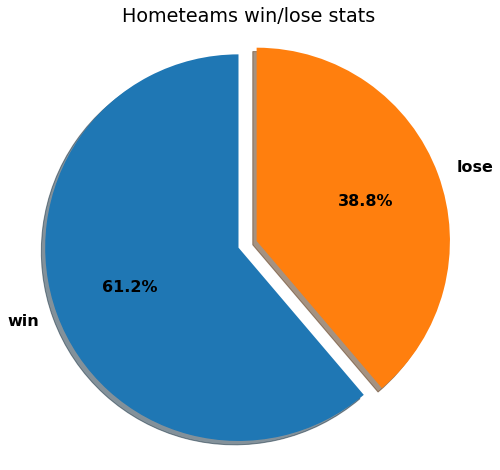

In [5]:
Y_train = np.array(Y_train)
count_win = Y_train[Y_train == "win"].shape[0]
count_lose = Y_train[Y_train == "lose"].shape[0]

fig1, ax1 = plt.subplots()
ax1.pie([count_win, count_lose], explode=[0.1,0], labels=["win", "lose"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Hometeams win/lose stats")
plt.show()


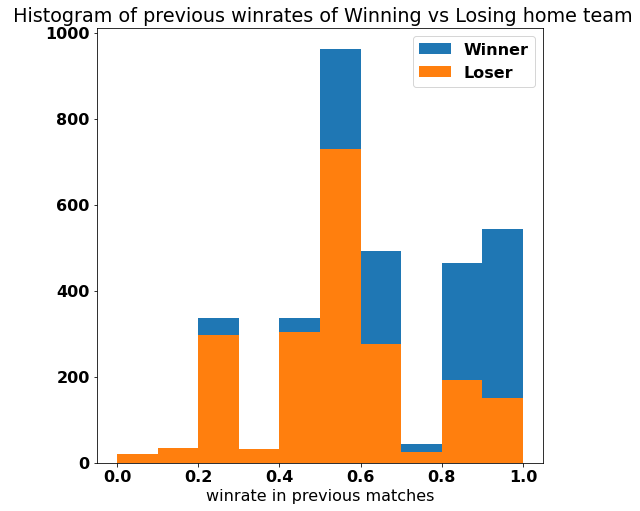

<Figure size 576x576 with 0 Axes>

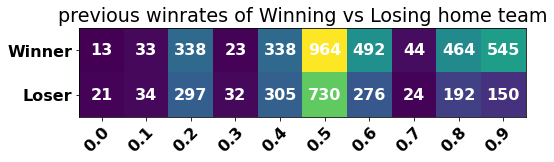

In [6]:
hwinrate = np.array([item[4] for item in X_train])


winhome = hwinrate[Y_train == "win"]
losehome = hwinrate[Y_train == "lose"]

counts1, bins = np.histogram(winhome)
plt.hist(bins[:-1], bins, weights=counts1)
counts2, bins = np.histogram(losehome)
plt.hist(bins[:-1], bins, weights=counts2)
plt.xlabel("winrate in previous matches")
plt.title(" Histogram of previous winrates of Winning vs Losing home team")
plt.legend(["Winner", "Loser"])
plt.figure()

hwinrates = [counts1, counts2]
fig, ax = plt.subplots()
im = ax.imshow(hwinrates)

# We want to show all ticks...
ax.set_xticks(np.arange(len(counts1)))
ax.set_yticks(np.arange(2))

# ... and label them with the respective list entries
ax.set_yticklabels(["Winner", "Loser"])
ax.set_xticklabels(["0.0","0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9","1.0"])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(len(counts1)):
        text = ax.text(j, i, hwinrates[i][j],
                       ha="center", va="center", color="w")

ax.set_title("previous winrates of Winning vs Losing home team")
plt.show()

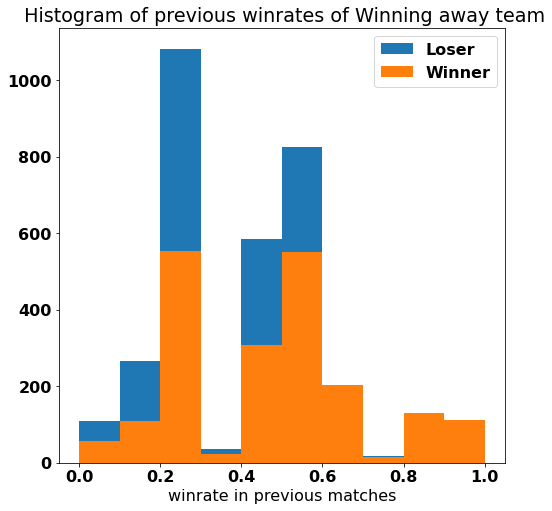

<Figure size 576x576 with 0 Axes>

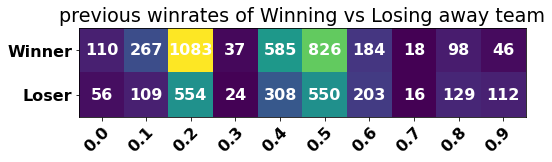

In [7]:
awinrate = np.array([item[5] for item in X_train])

winaway = awinrate[Y_train == "win"]
loseaway = awinrate[Y_train == "lose"]

counts1, bins = np.histogram(winaway)
plt.hist(bins[:-1], bins, weights=counts1)
counts2, bins = np.histogram(loseaway)
plt.hist(bins[:-1], bins, weights=counts2)
plt.xlabel("winrate in previous matches")
plt.title(" Histogram of previous winrates of Winning away team")
plt.legend(["Loser", "Winner"])
plt.figure()


awinrates = [counts1, counts2]
fig, ax = plt.subplots()
im = ax.imshow(awinrates)

# We want to show all ticks...
ax.set_xticks(np.arange(len(counts1)))
ax.set_yticks(np.arange(2))

# ... and label them with the respective list entries
ax.set_yticklabels(["Winner", "Loser"])
ax.set_xticklabels(["0.0","0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9","1.0"])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(len(counts1)):
        text = ax.text(j, i, awinrates[i][j],
                       ha="center", va="center", color="w")

ax.set_title("previous winrates of Winning vs Losing away team")
plt.show()

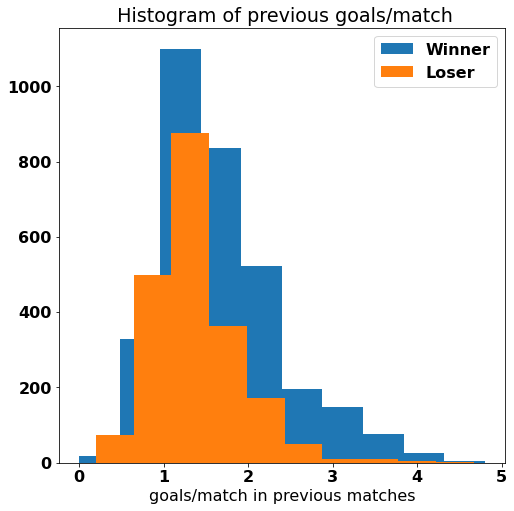

<Figure size 576x576 with 0 Axes>

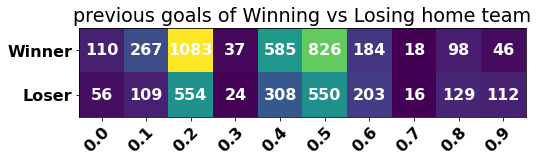

In [8]:
hgoals = np.array([item[0] for item in X_train])

goalshomewin = hgoals[Y_train == "win"]
goalshomelose = hgoals[Y_train == "lose"]
counts, bins = np.histogram(goalshomewin)
plt.hist(bins[:-1], bins, weights=counts)
counts, bins = np.histogram(goalshomelose)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel("goals/match in previous matches")
plt.title(" Histogram of previous goals/match")
plt.legend(["Winner", "Loser"])
plt.figure()


hgoals = [counts1, counts2]
fig, ax = plt.subplots()
im = ax.imshow(hgoals)

# We want to show all ticks...
ax.set_xticks(np.arange(len(counts1)))
ax.set_yticks(np.arange(2))

# ... and label them with the respective list entries
ax.set_yticklabels(["Winner", "Loser"])
ax.set_xticklabels(["0.0","0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9","1.0"])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(len(counts1)):
        text = ax.text(j, i, hgoals[i][j],
                       ha="center", va="center", color="w")

ax.set_title("previous goals of Winning vs Losing home team")
plt.show()

In [9]:
model = LogisticRegression()
#model = LinearRegression()
#model = make_pipeline(StandardScaler(), SVC(gamma='auto'))

normalize(X_train, axis=0, copy=False)
model.fit(X_train, Y_train)

LogisticRegression()

In [10]:
# Model evaluation
r = 0
falseneg = 0
falsepos = 0
for country in COUNTRIES:
    df = pd.read_csv ('./DistributedData/' + country + '/2017')
    df = df.sort_values(by=['date'], ascending= False)
    for index, row in df.iterrows():
        res = extract_features(df, row)
        if res is not None:
            prediction = model.predict(np.array(res["x"]).reshape(1,-1))
            if res["y"] == "draw":
                continue
            if prediction == res["y"]:
                r += 1
            else:
                if prediction == "win":
                    falsepos += 1
                else:
                    falseneg += 1
    
print ("Accuraccy = " + str (r / ( r + falseneg + falsepos)*100)[:5] + "%")
print("False Negative = " + str(falseneg))
print("False Positive = " + str(falsepos))

Accuraccy = 74.24%
False Negative = 40
False Positive = 71


In [11]:
r = 0
w = 0
for country in COUNTRIES:
    for year in YEARS:
        df = pd.read_csv ('./DistributedData/' + country + '/' + year)
        for index, row in df.iterrows():
            if row.fthg > row.ftag and row.odd_h > row.odd_a:
                r += 1
            elif row.fthg < row.ftag and row.odd_h > row.odd_a:
                w += 1
print ("Accuraccy = " + str(r / ( r + w)*100)[:5] + "%")

Accuraccy = 31.77%


## Notes
    - The model is the first of its type on this dataset, The accuraccy isn't that high because the problem is challenging
      as human accuracy on such problem is 31.77%
    - Mid table teams have no winning/losing patterns or they depend on other features not in dataset
    - We train on data between 2012 --> 2016 and evaluate on 2017 matches
    - We have tried SVM, Knn, Logistic regression, linear regression models and the problem is best fitted 
      with logistic regression
    - Last direct match between teams feature decreases the accuracy as it decreases the dataset if no match found
    - False positive number is high as data is slightly baised to home teams wins.
    